In [1]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import os
import codecs
import mpld3
import matplotlib.pyplot as plt
import seaborn
import pylab
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

# Load data and pick a sample of 10%
#data = pd.read_pickle("darklyrics/cleaned_lyrics.pkl")
stemmed_data = pd.read_pickle("darklyrics/stemmed_lyrics.pkl")
#data = data.sample(frac=0.1)

/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/jupyter_core/application.py:106: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="""Generate default config file."""
/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/jupyter_core/application.py:110: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="Specify a config file to load."
/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/jupyter_core/ap

## Counting distribution of words

In [13]:
count = 0
for index, row in data.iterrows():
    if 'see' in row['lyrics_string']:
        count += 1 
    
count

79737

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

begin = time()
word_vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english')
count_sparse_matrix = word_vectorizer.fit_transform(stemmed_data['lyrics_string'])
frequencies = sum(count_sparse_matrix).toarray()[0]
count_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
end = time()
print 'Count vectorization performed in %f seconds' % (end - begin)

count_df.head()

Count vectorization performed in 553.469943 seconds


,frequency
00,40
000,466
000lb,1
001,4
0096,1


In [3]:
from sklearn.preprocessing import normalize

total_docs = len(stemmed_data)
count_df['frequency_p'] = (count_df['frequency'] / float(total_docs)) * 100.0
labels = [str(x) for x in range(1, 101)]
labels.insert(0, '1 doc')
percentage_counts = []

for x in range(1, 101):
    percentage_counts.append(len(count_df[ (count_df.frequency_p >= x - 1) & (count_df.frequency_p < x) ]))
    
single_doc_count = len(count_df[count_df.frequency == 1])
percentage_counts[0] -= single_doc_count
percentage_counts.insert(0, single_doc_count)

#percentage_counts = [np.log(i) if i > 0.0 else 0.0 for i in percentage_counts]
print total_docs
print labels
print percentage_counts

189391
['1 doc', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']
[83994, 79359, 526, 222, 142, 81, 61, 36, 36, 22, 19, 8, 6, 13, 6, 11, 8, 6, 10, 4, 7, 4, 1, 1, 3, 3, 1, 2, 0, 5, 3, 1, 1, 4, 4, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


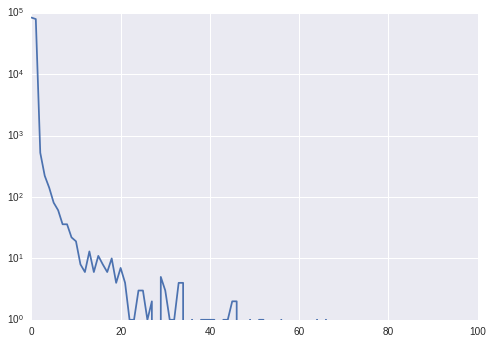

In [4]:
plt.plot(percentage_counts)
plt.yscale('log')
plt.show()

## TF-IDF Vectorization

In [14]:
begin = time()
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', min_df=2)
x = vectorizer.fit_transform(artist_data.values)
end = time()
print 'TFIDF vectorization performed in %f seconds' % (end - begin)
print 'Num samples: %d, num features: %d' % x.shape

TFIDF vectorization performed in 89.941398 seconds
Num samples: 7467, num features: 58195


### Results of stemming vs no stemming

**Documents:** 189123

#### Stemmed

##### Unigrams only
**Time:** 30.31s
**Features:** 67091

##### Bigrams
**Time:** 89.89s
**Features:** 1342971

#### Non-stemmed

##### Unigrams only
**Time:** 29.72s
**Features:** 94614

##### Bigrams
**Time:** 103.46
**Features:** 1442807


In [3]:
features = vectorizer.get_feature_names()

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

tfidf_sample = top_feats_in_doc(x, features, 1)
tfidf_sample

,feature,tfidf
0,wanted,0.418546
1,born,0.409128
2,disappoint,0.372452
3,expectations,0.306276
4,short,0.236385
5,accept,0.232083
6,failed,0.224275
7,tried,0.196489
8,let,0.180294
9,bothered,0.177616
